In [2]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.models import Model

from keras.preprocessing.image import load_img

In [3]:
#show labels

label = pd.read_csv('labels.csv')
label.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [4]:
label.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     c1ca7ec9bb04a6b33e8780cf944d3184  scottish_deerhound
freq                                   1                 126

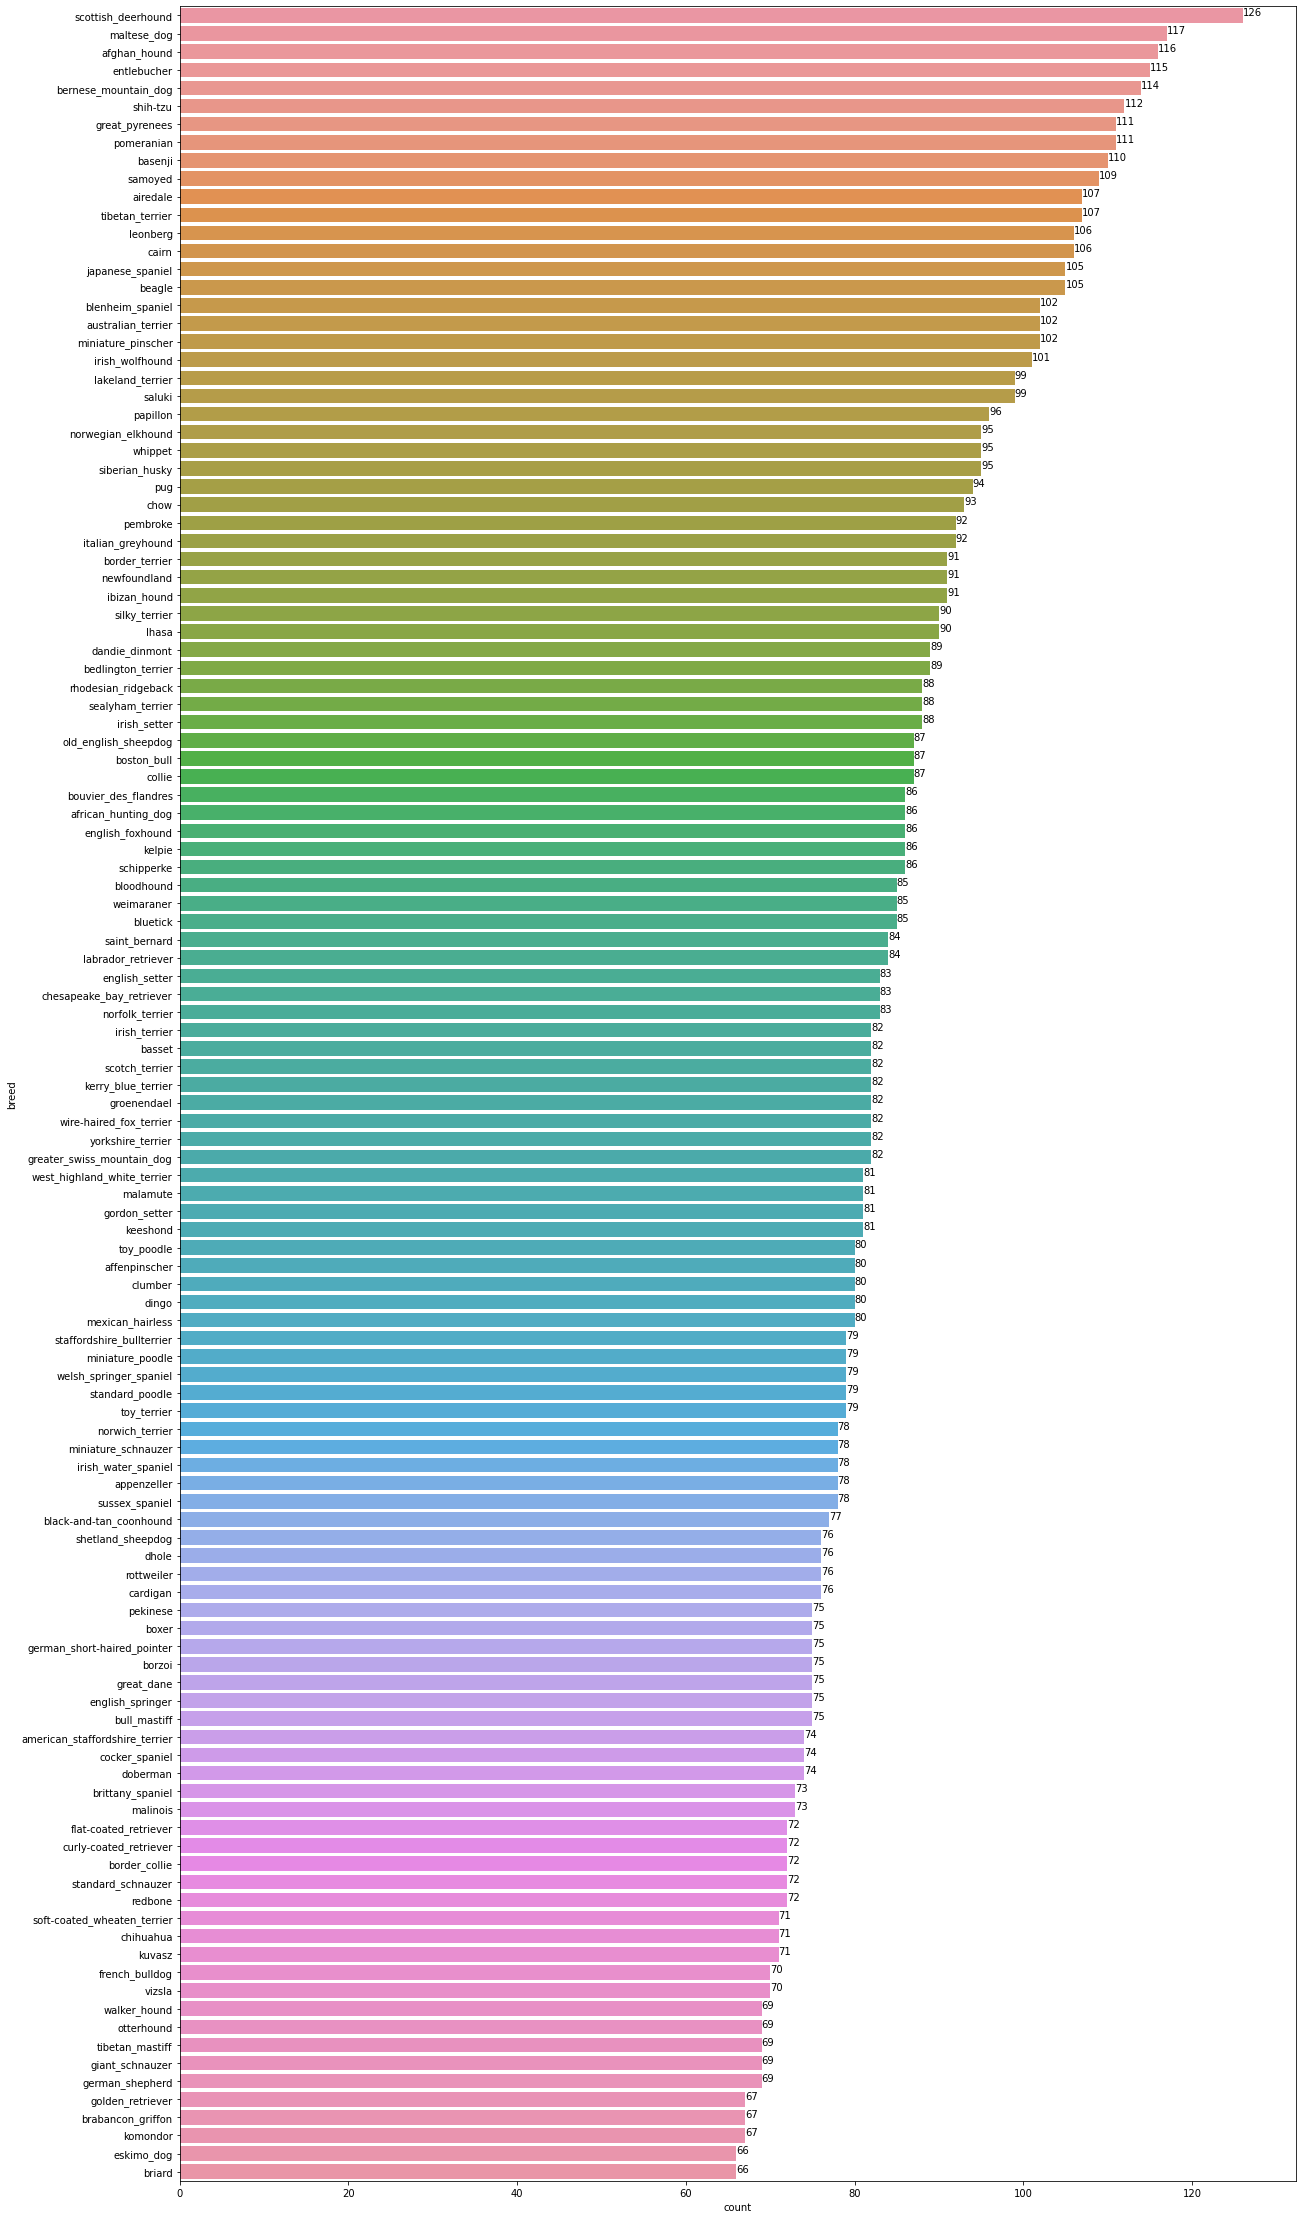

In [73]:
def cls(a):
    for i in a.patches:
        val = i.get_width()
        x = i.get_x() + i.get_width()
        y = i.get_y()+ i.get_height()/2
        a.annotate(round(val,2), (x,y))
plt.figure(figsize = (20, 40))
a1 = sns.countplot(y=label['breed'], order = label['breed'].value_counts().index)
cls(a1)
plt.show()

In [6]:

specis = sorted(list(set(label['breed'])))
n = len(specis)
print("Total breed {}".format(n))
d = dict(zip(specis, range(n)))
d

Total breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [7]:
input_shape = (331,331,3)

def img_arr(directory, label_dataframe, target_size = input_shape):
    
    img_label = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]], dtype = np.uint8)
    y = np.zeros([len(label_dataframe), 1],dtype = np.uint8)
    for i, name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[i] = img
        del img
        dog_breed = img_label[i]
        y[i] = d[dog_breed]
    y = to_categorical(y)
    return images, y

In [8]:
import os
if len(os.listdir('C:/Users/Deep Mukherjee/OneDrive/Desktop/New folder/train/')) == len(label['id']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file doesnot matches number of actual images!!')

Number of file matches number of actual images!


In [9]:
import time 
t = time.time()

X,y = img_arr('C:/Users/Deep Mukherjee/OneDrive/Desktop/New folder/train/', label[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 223.36776304244995


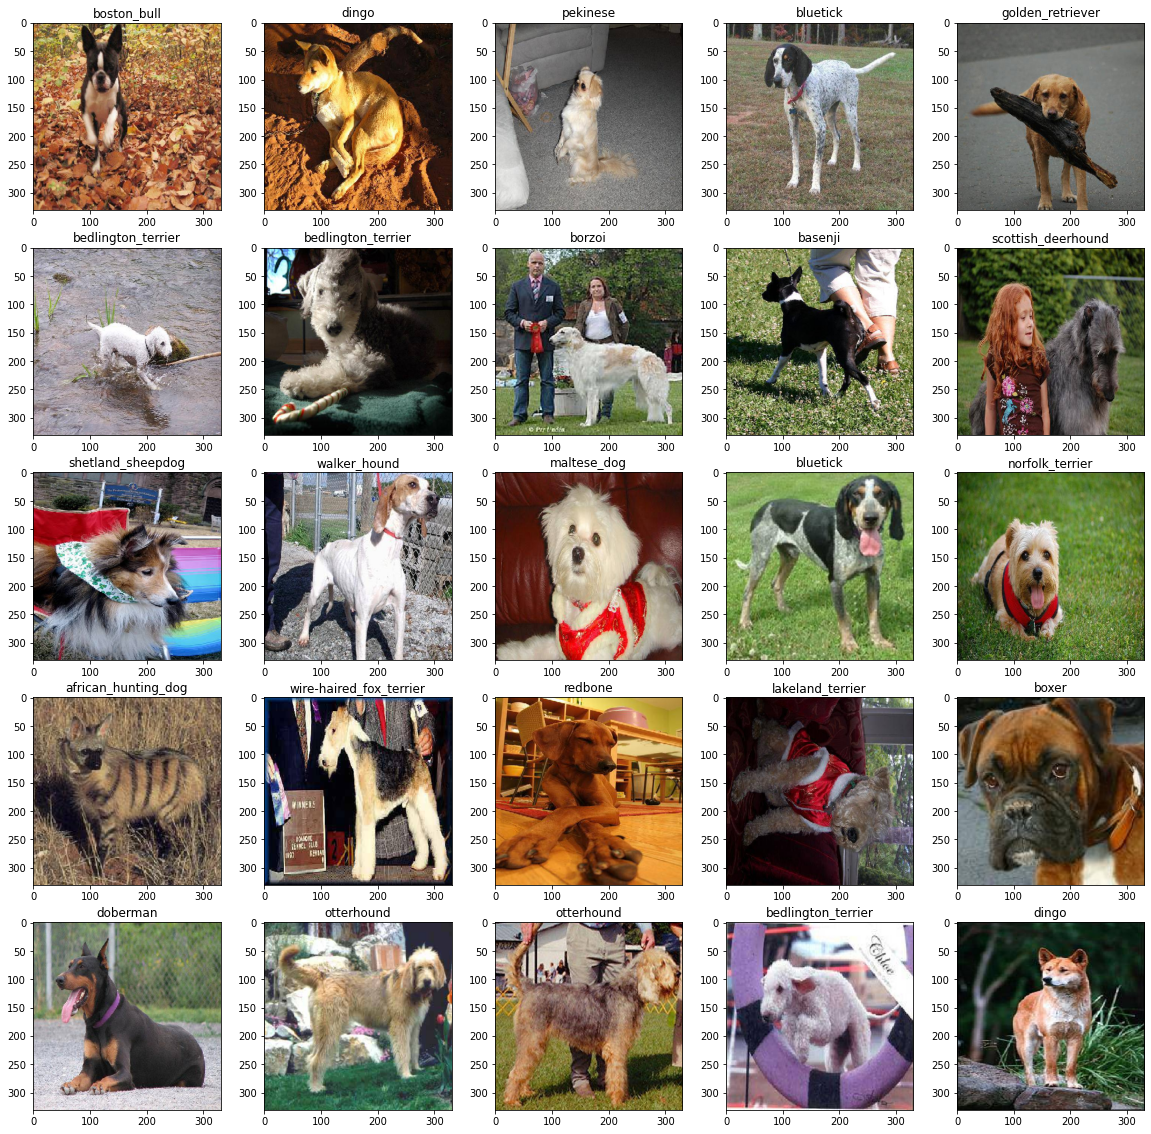

In [10]:
p=25

# setup the figure 
plt.figure(figsize=(20,20))

for i in range(p):
#     print(i)
    a = plt.subplot(5, 5, i+1)
    plt.title(specis[np.where(y[i] == 1)[0][0]])
    plt.imshow(X[i].astype('int32')) # .astype('int32') ---> as imshow() needs integer data to read the image


In [11]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
# Hyperparameters
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [49]:
image_size=(224,224)

In [13]:
#function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [14]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X) 

320/320 [==============================] - 1214s 4s/step
Feature maps shape:  (10222, 2048)


In [15]:
# Extract features using Xception 
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

320/320 [==============================] - 2277s 7s/step
Feature maps shape:  (10222, 2048)


In [16]:
 # Extract features using InceptionResNetV2 
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X
                                   

320/320 [==============================] - 3009s 9s/step
Feature maps shape:  (10222, 1536)


In [17]:
# Extract features using NASNetLarge 
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

320/320 [==============================] - 6798s 21s/step
Feature maps shape:  (10222, 4032)


In [18]:
del X #to free up some ram memory
gc.collect() 

233568

In [19]:
#Creating final featuremap by combining all extracted features

final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1) #axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 9664)


In [20]:
#Prepare Deep net

model = Sequential() 
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/50
64/64 [==============================] - 19s 232ms/step - loss: 2.2038 - accuracy: 0.5771 - val_loss: 0.2001 - val_accuracy: 0.9364
Epoch 2/50
64/64 [==============================] - 2s 29ms/step - loss: 0.1738 - accuracy: 0.9464 - val_loss: 0.1936 - val_accuracy: 0.9394
Epoch 3/50
64/64 [==============================] - 2s 30ms/step - loss: 0.1271 - accuracy: 0.9616 - val_loss: 0.1882 - val_accuracy: 0.9389
Epoch 4/50
64/64 [==============================] - 2s 29ms/step - loss: 0.1087 - accuracy: 0.9647 - val_loss: 0.1861 - val_accuracy: 0.9403
Epoch 5/50
64/64 [==============================] - 2s 31ms/step - loss: 0.0909 - accuracy: 0.9701 - val_loss: 0.1921 - val_accuracy: 0.9379
Epoch 6/50
64/64 [==============================] - 2s 31ms/step - loss: 0.0743 - accuracy: 0.9771 - val_loss: 0.1842 - val_accuracy: 0.9399
Epoch 7/50
64/64 [==============================] - 2s 31ms/step - loss: 0.0679 - accuracy: 0.9810 - val_loss: 0.1829 - val_accuracy: 0.9408
Epoch 8/50


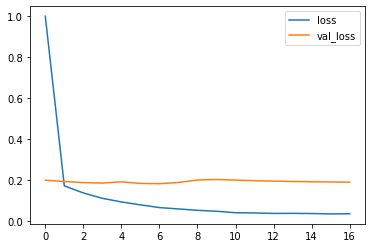

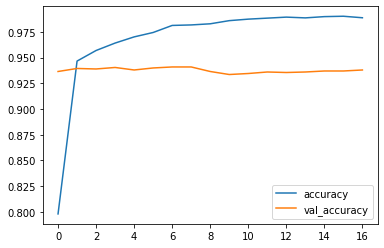

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();


In [72]:
#deleting to free up ram memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

6606

In [21]:
sample = pd.read_csv('sample_submission.csv')

In [22]:
sample.shape

(10357, 121)

In [23]:
sample.describe()

affenpinscher  afghan_hound  african_hunting_dog      airedale  \
count   10357.000000  10357.000000         10357.000000  10357.000000   
mean        0.008333      0.008333             0.008333      0.008333   
std         0.000000      0.000000             0.000000      0.000000   
min         0.008333      0.008333             0.008333      0.008333   
25%         0.008333      0.008333             0.008333      0.008333   
50%         0.008333      0.008333             0.008333      0.008333   
75%         0.008333      0.008333             0.008333      0.008333   
max         0.008333      0.008333             0.008333      0.008333   

       american_staffordshire_terrier   appenzeller  australian_terrier  \
count                    10357.000000  10357.000000        10357.000000   
mean                         0.008333      0.008333            0.008333   
std                          0.000000      0.000000            0.000000   
min                          0.008333      0.008333            0.008333   
25%                          0.008333      0.008333            0.008333   
50%                          0.008333      0.008333            0.008333   
75%                          0.008333      0.008333            0.008333   
max                          0.008333      0.008333            0.008333   

            basenji        basset        beagle  ...    toy_poodle  \
count  10357.000000  10357.000000  10357.000000  ...  10357.000000   
mean       0.008333      0.008333      0.008333  ...      0.008333   
std        0.000000      0.000000      0.000000  ...      0.000000   
min        0.008333      0.008333      0.008333  ...      0.008333   
25%        0.008333      0.008333      0.008333  ...      0.008333   
50%        0.008333      0.008333      0.008333  ...      0.008333   
75%        0.008333      0.008333      0.008333  ...      0.008333   
max        0.008333      0.008333      0.008333  ...      0.008333   

        toy_terrier        vizsla  walker_hound    weimaraner  \
count  10357.000000  10357.000000  10357.000000  10357.000000   
mean       0.008333      0.008333      0.008333      0.008333   
std        0.000000      0.000000      0.000000      0.000000   
min        0.008333      0.008333      0.008333      0.008333   
25%        0.008333      0.008333      0.008333      0.008333   
50%        0.008333      0.008333      0.008333      0.008333   
75%        0.008333      0.008333      0.008333      0.008333   
max        0.008333      0.008333      0.008333      0.008333   

       welsh_springer_spaniel  west_highland_white_terrier       whippet  \
count            10357.000000                 10357.000000  10357.000000   
mean                 0.008333                     0.008333      0.008333   
std                  0.000000                     0.000000      0.000000   
min                  0.008333                     0.008333      0.008333   
25%                  0.008333                     0.008333      0.008333   
50%                  0.008333                     0.008333      0.008333   
75%                  0.008333                     0.008333      0.008333   
max                  0.008333                     0.008333      0.008333   

       wire-haired_fox_terrier  yorkshire_terrier  
count             10357.000000       10357.000000  
mean                  0.008333           0.008333  
std                   0.000000           0.000000  
min                   0.008333           0.008333  
25%                   0.008333           0.008333  
50%                   0.008333           0.008333  
75%                   0.008333           0.008333  
max                   0.008333           0.008333  

[8 rows x 120 columns]

In [24]:
#Function to read images from test directory

def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
        img = load_img(img_dir, target_size = img_size)
        images[ix]=img
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('C:/Users/Deep Mukherjee/OneDrive/Desktop/New folder/test/', img_size)


  0%|          | 0/10357 [00:00<?, ?it/s]

Ouptut Data Size:  (10357, 331, 331, 3)


In [42]:
#Extract test data features.
def extact_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()
    
    
    
    
    return final_features

test_features = extact_features(test_data)

324/324 [==============================] - 1632s 5s/step
Feature maps shape:  (10357, 2048)
324/324 [==============================] - 2406s 7s/step
Feature maps shape:  (10357, 2048)
324/324 [==============================] - 6927s 21s/step
Feature maps shape:  (10357, 4032)
324/324 [==============================] - 4112s 13s/step
Feature maps shape:  (10357, 1536)
Final feature maps shape (10357, 9664)


In [43]:
#Free up some space.
del test_data
gc.collect()

77

In [44]:
#Predict test labels given test data features.

pred = model.predict(test_features)

In [46]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {specis[np.argmax(pred[0])]}")


[6.97126609e-07 3.34945014e-07 4.96003281e-07 6.34278976e-08
 4.21576623e-08 5.19530197e-08 2.39129658e-08 1.44865652e-07
 7.56741443e-08 9.20825656e-08 1.16455780e-07 3.02771923e-07
 1.61944868e-07 7.09420856e-05 2.94801907e-07 3.11255008e-07
 1.15651602e-07 6.16749105e-08 3.85584002e-07 3.60901026e-07
 5.20112167e-08 1.40373186e-06 1.15574255e-06 1.03622675e-07
 1.35204999e-07 2.52102382e-07 1.02527364e-08 3.44248896e-08
 1.63567805e-07 7.89550995e-07 2.30630405e-07 4.54069124e-07
 5.74442367e-07 5.42254725e-07 1.58035093e-07 4.73960604e-08
 8.81052671e-08 1.16157295e-07 6.97645746e-08 5.43904832e-07
 1.44667936e-07 4.77911222e-08 2.17125503e-07 5.92341749e-08
 1.92785663e-07 6.25810344e-07 5.24002566e-08 3.84987118e-08
 6.76292302e-08 4.11407115e-07 4.84263012e-07 6.76254928e-08
 3.45042167e-07 1.94252507e-07 4.42554047e-08 1.22349931e-07
 8.71555770e-08 1.37348124e-08 3.20962741e-08 1.90751450e-07
 8.33783744e-08 9.96177673e-01 7.75728324e-07 1.87589091e-08
 5.38114655e-08 6.500032

In [67]:
# Create pandas DataFrame with empty columns
preds = pd.DataFrame(columns=["id"] + list(specis))
preds.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [68]:
# Append test image ID's to predictions DataFrame
test_path = "C:/Users/Deep Mukherjee/OneDrive/Desktop/New folder/test"
preds["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds.head()

id affenpinscher afghan_hound  \
0  000621fb3cbb32d8935728e48679680e           NaN          NaN   
1  00102ee9d8eb90812350685311fe5890           NaN          NaN   
2  0012a730dfa437f5f3613fb75efcd4ce           NaN          NaN   
3  001510bc8570bbeee98c8d80c8a95ec1           NaN          NaN   
4  001a5f3114548acdefa3d4da05474c2e           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [71]:
preds.loc[:,list(specis)]= pred

preds.to_csv('submission.csv',index=None)
preds.head()

id affenpinscher afghan_hound  \
0  000621fb3cbb32d8935728e48679680e   6.97127e-07  3.34945e-07   
1  00102ee9d8eb90812350685311fe5890   5.19003e-07  5.88614e-07   
2  0012a730dfa437f5f3613fb75efcd4ce    2.2693e-07  1.55325e-05   
3  001510bc8570bbeee98c8d80c8a95ec1    7.2418e-06  4.37836e-07   
4  001a5f3114548acdefa3d4da05474c2e    0.00680709  3.80366e-05   

  african_hunting_dog     airedale american_staffordshire_terrier  \
0         4.96003e-07  6.34279e-08                    4.21577e-08   
1          3.4789e-07  2.81492e-07                    3.38396e-07   
2         5.29675e-06  3.69361e-07                     9.7763e-08   
3          7.5678e-07  3.31999e-07                    1.77027e-07   
4         4.67025e-05   4.7863e-06                    2.20443e-06   

   appenzeller australian_terrier      basenji       basset  ...   toy_poodle  \
0   5.1953e-08         2.3913e-08  1.44866e-07  7.56741e-08  ...   1.0931e-06   
1  1.06825e-06        1.32767e-07  1.23556e-06  1.95081e-07  ...  2.12602e-06   
2  1.13959e-06        4.25453e-08  2.61326e-07  1.12024e-06  ...  8.03046e-07   
3    3.472e-07        1.88636e-08  9.44334e-07  1.48319e-07  ...  1.05872e-06   
4   1.8604e-05        2.65604e-05  3.74418e-05  3.30942e-05  ...  5.31745e-05   

   toy_terrier       vizsla walker_hound   weimaraner welsh_springer_spaniel  \
0  2.05651e-07  6.14932e-07  1.19021e-07  1.31067e-07            1.29309e-07   
1  4.94851e-07  1.53323e-06  3.23455e-06  1.11285e-06            4.39941e-07   
2  7.95151e-07  1.85532e-06  1.24554e-06  7.10776e-06            4.35861e-06   
3  1.92042e-07  1.44426e-06  6.15368e-07   3.1311e-07            1.13582e-07   
4  5.60145e-05  3.70336e-05  5.36144e-05  1.80033e-05            5.96402e-06   

  west_highland_white_terrier      whippet wire-haired_fox_terrier  \
0                 5.90891e-08   1.2391e-07              2.0106e-07   
1                 9.17611e-06  1.35094e-06             3.80763e-07   
2                  3.4713e-08  1.70396e-06             4.33164e-07   
3                 1.24466e-07  1.19802e-05             5.23133e-09   
4                 4.73153e-06  0.000222238              6.6105e-06   

  yorkshire_terrier  
0       4.15229e-07  
1       1.71175e-06  
2       1.40283e-06  
3       4.77698e-07  
4       0.000140176  

[5 rows x 121 columns]